# Exercise 3: Dynamic Programming
Giorgia Ramponi, Sean Boos


## Requirements

In [ ]:
# Set up the environment (not needed for local installations)
!pip install "git+https://github.com/rlsummerschool/practical-sessions.git" --quiet

import time
import random

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 29.2 MB/s eta 0:00:00


## The Gym(nasium) interface

[Gymnasium](https://gymnasium.farama.org/) is a standard API for Decision Processes, based on OpenAI's Gym library.

In [ ]:
# Standard import
import gymnasium as gym
from gymnasium import Env

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


The library also defines a number of classic benchmarks [Atari](https://gymnasium.farama.org/environments/atari/) games, [MuJoCo](https://gymnasium.farama.org/environments/mujoco/) simulations, and [ToyText](https://gymnasium.farama.org/environments/toy_text/), minimal environments for debugging.


In [ ]:
# A registered environment (for example Cliff Walking) can be instantiated with
env = gym.make("CliffWalking-v0")

# Important properties:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


We only consider discrete state and action spaces. See the possible alternatives: `dir(gym.spaces)`

Environments can be fully observable, partially observable or non-stationary. All these variants fit the same environment interface.
We should know which class our environment belongs to.
Today, we only consider stationary and fully observable MDPs.

The environment interface allows  to sample initial states and transition with `env.reset()` and `env.step(action)`. Every method is well documented (see `help(gym.Env.step)`).

Try it out!

In [ ]:
observation, info = env.reset()
print(f"Initial observation: {observation}")

action = 0  # any action

observation, reward, terminated, truncated, info = env.step(action)
print(f"Observation: {observation}, reward {reward}")

observation, reward, terminated, truncated, info = env.step(action)
print(f"Observation: {observation}, reward {reward}")

observation, reward, terminated, truncated, info = env.step(action)
print(f"Observation: {observation}, reward {reward}")

Initial observation: 36
Observation: 24, reward -1
Observation: 12, reward -1
Observation: 0, reward -1


Custom environments can be created by subclassing the `Env` class.

Environments can be also modified with wrappers. See the predefined Gymnasium [Wrappers](https://gymnasium.farama.org/api/wrappers/#gymnasium-wrappers).




## The Markov Decision Problem (MDP)



We experiment with a simple grid-world environment, based on the implementation in [minigrid](https://minigrid.farama.org/environments/minigrid/). The environment is configured and observations are transformed appropriately (you already know how). Our Agent is on a 3 x 3 grid and starts on the field (1, 1). The agent receives a reward of 1 for any action taken at the goal field (3, 3). The failure parameter describes the probability that the agent randomly executes another action than the one intended. We are setting it to zero for now. This means the transitions betwewwn states are determinisitc. The size parameter defines the size of the room. The horizon is set to 50.

In [ ]:
from rlss_practice.environments import Room, MinigridBase


# Initializing the environment
env = Room(
    failure=0.0,  # probability that the agent randomly executes another action than the one intended -> transitions betwewwn states are determinisitc
    agent_start_pos=(1, 1),
    agent_start_dir=0,
    size=5,
)
print(env)

WWWWW
W>  W
W   W
W  GW
WWWWW


In this ASCII representation, > is the agent, facing right, G is the goal, and W are walls.

Understand you own environment:

In [ ]:
print("Action space:", env.action_space)
print("Observation space:", env.observation_space, end="\n\n")
#print(help(MinigridBase))

Action space: Discrete(3)
Observation space: MultiDiscrete([5 5 4])



When you checkout `help(env)`:

    class MinigridBase
       MinigridBase(minigrid: minigrid.minigrid_env.MiniGridEnv, seed: int, failure=0.0)

       Base class for minigrid environments with explicit transition and reward functions.

       The agent is rewarded upon reaching the goal location.

       Action space:

       | Num | Name         | Action       |
       |-----|--------------|--------------|
       | 0   | left         | Turn left    |
       | 1   | right        | Turn right   |
       | 2   | forward      | Move forward |

       Observation space:

       | Name | Description             |
       |------|-------------------------|
       | x    | x coordinate            |
       | y    | y coordinate (downward) |
       | dir  | cardinal direction      |

       The transition function is stored in `T`,
       where `T[state][action][next_state]` is the transition probability.
       The reward function is `R`. `R[state][action]` contains a reward.

### Demo

Here's a rollout loop, for a single trajectory

In [ ]:
# Test it
done = False
observation, info = env.reset()
print("Initial observation:", observation)  # [row, column, direction]
print(env)

# Steps
while not done:

    try:
      # Action selection

      action = int(input("Action: "))

      # Transition
      observation, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      print(f"Observation: {observation}, reward {reward}, terminated {terminated}, truncated {truncated}")
      print(env)

    except:
      done = True
      print("Invalid action or KeyboardInterrupt")


Initial observation: [1 1 0]
WWWWW
W>  W
W   W
W  GW
WWWWW
Action: 2
Observation: [2 1 0], reward 0.0, terminated False, truncated False
WWWWW
W > W
W   W
W  GW
WWWWW
Action: 2
Observation: [3 1 0], reward 0.0, terminated False, truncated False
WWWWW
W  >W
W   W
W  GW
WWWWW
Action: 1
Observation: [3 1 1], reward 0.0, terminated False, truncated False
WWWWW
W  VW
W   W
W  GW
WWWWW
Action: 2
Observation: [3 2 1], reward 0.0, terminated False, truncated False
WWWWW
W   W
W  VW
W  GW
WWWWW
Action: 2
Observation: [3 3 1], reward 0.0, terminated False, truncated False
WWWWW
W   W
W   W
W  VW
WWWWW
Action: 2
Observation: [0 0 0], reward 1.0, terminated True, truncated False
WWWWW
W   W
W   W
W  VW
WWWWW


We can define a function that performs `n_trajectories` rollouts on the environment with a given policy. We can also compute arbitrary statistics in the meanwhile.

In [ ]:
def rollouts(env, policy, n_trajectories, gamma):
    """Execute policy over env for n_trajectories and compute discounted return."""
    total_return = 0.0

    # Trajectores
    for _ in range(n_trajectories):

        # Init
        discount = 1.0
        ret = 0.0
        observation, info = env.reset()
        done = False

        # Steps
        while not done:

            # Action selection
            action = policy(observation)

            # Transition
            observation, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            ret += reward * discount
            discount *= gamma

            if done:
                total_return += ret

    env.close()
    return total_return / n_trajectories

Since we don't have a policy yet, let's define the uniform one.

In [ ]:
class UniformPolicy():
    def __init__(self, n_actions: int):
        self.n_actions = n_actions

    def __call__(self, observation):
        return random.randint(0, self.n_actions-1)

Let's try:

In [ ]:
avg_return = rollouts(env=env,
                      policy=UniformPolicy(env.action_space.n),
                      n_trajectories=20,
                      gamma=0.9)

print(avg_return)

0.04097296753446837


We can also visualize the execution:

In [ ]:
from rlss_practice.wrappers import Renderer
visible_env = Renderer(env)

In [ ]:
avg_return = rollouts(env=visible_env,
                      policy=UniformPolicy(env.action_space.n),
                      n_trajectories=1,
                      gamma=0.9)

print(avg_return)

0.0


In [ ]:
visible_env.play()

Finally, a small utility for creating callable objects from state-action mappings

In [ ]:
def make_policy(policy_dict):
  """Return the policy dictionary as a callable object"""

  def callable_policy(observation):
      return policy_dict[tuple(observation.tolist())]

  return callable_policy

### Explicit model

The algorithms we will implement require that a complete model of the environment is available, in the form of explicit transition and reward functions. This is not part of the gym interface.

These two functions are stored in two members:

In [ ]:
# Transition and reward functions
T = env.T # T[state][action][next_state]
R = env.R # R[state][action]

# These are represented as dictionaries (for maximum clarity)
#   and indexed as T[state][action][next_state]
print("A few probabilities")
print(T[(1, 1, 0)][2][(2, 1, 0)])
print(T[(1, 1, 0)][2][(1, 1, 1)])
print(T[(3, 1, 0)][1][(3, 1, 1)])

#   also R[state][action]
print("\nA few rewards")
print(R[(1, 1, 0)][2])
print(R[(3, 3, 0)][0])

A few probabilities
1.0
0.0
1.0

A few rewards
0.0
1.0


In [ ]:
# env.pretty_print_T()

In [ ]:
# Explicit set of states and actions

print("States", env.states)
print("Actions", env.actions)
print("Number of states", len(env.states))
print("Number of actions", len(env.actions))

States [(1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3), (0, 0, 0)]
Actions [0, 1, 2]
Number of states 37
Number of actions 3


In [ ]:
# Some classic imports for the rest of the notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

mpl.style.use('seaborn-v0_8')

## Solving the MDP


### Theory Recap
We would like to find a the optimal policy
$$\pi^*: S \rightarrow A, $$
$$\text{s.t. } V^*(s) \geq V^\pi(s), \forall s, \forall \pi$$



&nbsp;

---

&nbsp;

**Motivation for Dynamic Programming in Reinforcement Learning**

Dynamic Programming (DP) is **motivated by the need to efficiently solve the problem of finding the optimal policy $\pi^*$** when both the transition dynamics and the reward structure of the environment are known. DP leverages the Bellman equations to iteratively improve value estimates, allowing for systematic convergence to the optimal value function and policy. Essentially, the value functions represent a set of equations that can be solved directly to find the optimal policy; however, this approach is computationally expensive, as it typically requires matrix inversion, which becomes infeasible for large state spaces.

In order to apply DP techniques, it is **necessary to have**:
Model dynamics, specifically:
 * The **transition probabilities** $P(s' \mid s, a)$, which describe the probability of transitioning from state $s$ to state $s'$ after taking action $a$.
 * The **reward function** $r(s, a)$, which specifies the reward received for taking action $a$ in state $s$.




Recall that the **state value function** for $s\in \mathcal{S}$ denoted

$$V^\pi(s)=\sum_{a \in A} \pi(a \mid s)\left[r(s, a)+\sum_{s^{\prime} \in S} P\left(s^{\prime} \mid s, a\right) \gamma V\left(s^{\prime}\right)\right]$$

$$V^\pi(s)=r(s, \pi(s))+\sum_{s^{\prime} \in S} P\left(s^{\prime} \mid s, \pi(s)\right) \gamma V\left(s^{\prime}\right), \quad \text{(if the policy is deterministic)}$$


represents the value of being in state $s$ and following policy $\pi$.

The **state action value function** for $s\in \mathcal{S}, a\in \mathcal{A}$ denoted

$$ Q^\pi(s,a) = r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a) V^{\pi}(s')$$

is the value of first taking an action $a$ in state $s$ then following policy $\pi$.


Given a function $Q: S \times A \rightarrow \mathbb{R}$, the **Bellman Optimality Operator** is $\mathcal{T} Q: S \times A \rightarrow \mathbb{R}$:

$$(\mathcal{T} Q)(s, a):=r(s, a)+\gamma \sum_{s^{\prime}} P\left(s^{\prime} \mid s, a\right) \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)$$

Recall that $Q^*$ is a fix-point for the Bellman Optimality Operator:
$$
Q^*(s, a)=\left(\mathcal{T} Q^*\right)(s, a)=r(s, a)+\gamma \sum_{s^{\prime}} P\left(s^{\prime} \mid s, a\right) \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)
$$
The use of the Bellman optimality operator ensures convergence to the optimal policy and its corresponding optimal value functions.

&nbsp;

---

&nbsp;

With the transition and reward function of the grid-world task available to us, we attempt to find an optimal policy via **Dynamic programming**. Precisely, we implement **Policy Iteration** and **Value iteration** methods introduced in the first lecture.

&nbsp;

### Notation

*   $r_{\pi}\in\mathbb{R}^{|\mathcal{S}|}$ so that for $s\in\mathcal{S}$, $r_{\pi}(s) = r(s,\pi(s))$.
*   $p_{\pi}\in\mathbb{R}^{|\mathcal{S}|\times|\mathcal{S}|}$ so that for $s,s'\in\mathcal{S}$, $p_{\pi}(s'|s) = p(s'|s,\pi(s))$.
*   $n_{k}$ is the number of loops required to compute $V_{k}$
*   $\Delta$ is a threshold on the accuracy of value estimation [[3]](#scrollTo=XqJPFe6f6gFV&line=5&uniqifier=1)

&nbsp;

In [ ]:
# Don't look at the solutions! This module contains the functions you should write
from rlss_practice import dp_solutions

### Policy Iteration

**Idea**

Gradually advance to $\pi^{*}$ from an initial guess $\pi_0$ through a series of **policy evaluation** and **policy improvement** steps.

&nbsp;


**Policy Evaluation step**

Given a policy $\pi_k$, estimate $V^{\pi_k}$ as $V_{k}$ with the following iterations

  * Initialize $V$ as $\mathbf{0}$ when $k = 0$ and $V_{k-1}$ otherwise, let $\pi = \pi_k$

    <div>
    <img src="https://drive.google.com/uc?export=view&id=1QaMg7a6HELjYycAnm6RE9vnzHD_fnaCn" alt="iterative policy evaluation" width="600"/>
    </div>

    Return $V_k = V$. <!--$(T^{\pi_{k}})^{n_{k}}V_{k-1}$-->

&nbsp;

**Policy Improvement step**

Obtain $\pi_{k+1}$ as the greedy policy w.r.t $V^{\pi_k}$ (or $V_{k}$). That is,
$$ \pi_{k+1}(s) \in \underset{a\in\mathcal{A}}{\arg\max} \bigg\{r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a)V^{\pi_{k}}(s')\bigg\},\quad s\in\mathcal{S}$$

&nbsp;

#### Putting everything together

Starting from an arbitrary stationary deterministic markovian policy $\pi_{0}$, for $k = 0,1,2,\cdots, K$ do:
* Estimate $V^{\pi_k}$ with $V_{k}=(T^{\pi_{k}})^{n_{k}}V_{k-1}$
* Obtain $\pi_{k+1}$ as the greedy policy w.r.t $V^{\pi_k}$
* Terminate loop if policy is stable (i.e $\pi_{k+1}(s) = \pi_{k}(s)$ for all $s\in\mathcal{S}$) and return $\pi_{k+1}$.

In [ ]:
class PolicyIteration:
  """
  Implements policy iteration
  """
  def __init__(self, env: Env, gamma: float, theta: float, initial_policy = None):
    # Store
    self.env = env
    self.states = self.env.states
    self.n_states = len(self.states)
    self.actions = self.env.actions
    self.n_actions = len(self.actions)
    self.gamma = gamma
    self.theta = theta
    self.policy = initial_policy

    # Default policy
    if self.policy == None:
      np.random.seed(4)
      self.policy = {state: np.random.randint(0, self.n_actions-1) for state in self.states}

    self.policy_stable = False
    self.V = {state: 0.0 for state in env.states}
    self.V_logs = []


  def evaluate_policy(self):
    dp_solutions.ModifiedPolicyIteration.evaluate_policy(self)


  def get_p_pi(self):
    """
    Given π_{k}, compute p_{π_{k}}
    """
    p_pi = np.zeros((self.n_states,self.n_states))

    for s_index, s in enumerate(self.states):
      for snext_index, snext in enumerate(self.states):
        p_pi[s_index, snext_index] = self.env.T[s][self.policy[s]][snext]

    return p_pi


  def get_r_pi(self):
    """
    Given π_{k}, compute r_{π_{k}}
    """
    r_pi = np.zeros((self.n_states,1))

    for i, state in enumerate(self.states):
      r_pi[i][0] = self.env.R[state][self.policy[state]]

    return r_pi


  def get_expected_update(self, state, action):
    """
    Compute:

      Q(s,a) = r(s,a) + gamma <p(.|s,a),V>

    :param state
    :param action

    :return Q(s,a): float
    """
    # TODO: Solve this and return Q(s,a) instead
    # return dp_solutions.PolicyIteration.get_expected_update(self, state, action)
    value  = self.env.R[state][action]

    for snext in self.states:
      value += self.gamma * self.env.T[state][action][snext] * self.V[snext]

    return value


  def _evaluate_policy(self):
    """
    Given 'policy' π_{k},
    Starting from a previous guess 'V_{k-1}',
    iteratively estimate V^{π_{k}} as T^{π_{k}}V_{k-1}.

    assign new state values to self.V
    """
    max_value_gap = np.inf

    while max_value_gap > self.theta:
      max_value_gap = 0

      for state in self.env.states:
        prev_statevalue = self.V[state]
        self.V[state] = self.get_expected_update(state, self.policy[state])
        max_value_gap = max(max_value_gap, np.abs(prev_statevalue - self.V[state]))

    self.V_logs.append(self.V.copy())


  def get_policy(self):
    """
    Get the greedy policy:

      π_{k+1}(s) = argmax_{a\in A} Q^{\pi_{k}}(s,a)

    where

      Q^{\pi_{k}}(s,a) = r(s,a) + gamma * <P(.|s,a),V^{\pi_{k}}>

    assign new policy to self.policy
    update self.policy_stable
    """
    self.policy_stable = True

    for state in self.states:
      max_Q_value = self.get_expected_update(state, self.policy[state])

      for action in self.actions:
        Q_value = self.get_expected_update(state, action)

        if action != self.policy[state] and max_Q_value < Q_value:
          self.policy[state] = action
          max_Q_value = Q_value
          self.policy_stable = False
    return



Now we run policy iteration

In [ ]:
PI_planner = PolicyIteration(env, gamma = 0.9, theta = 0.01)

while not PI_planner.policy_stable:
  PI_planner.evaluate_policy()
  PI_planner.get_policy()

In [ ]:
avg_return = rollouts(env=visible_env,
                      policy=make_policy(PI_planner.policy),
                      n_trajectories=80,
                      gamma=0.9)

print(avg_return)

0.5904900000000006


In [ ]:
def visualize(vlogs, state, grid_size):
  grid_size -= 2   # walls

  # Initial state values
  fig1 = plt.figure(figsize=(4, 3))
  ax1 = fig1.subplots()
  ax1.set_ylabel("value of (1,1,0)")
  ax1.set_xlabel("iterations")
  initial_state_values = [value[(1, 1, 0)] for value in PI_planner.V_logs]
  ax1.plot(range(len(initial_state_values)), initial_state_values)

  # States values over time
  some_values_over_time = [
    {(x, y): values[(x, y, o)] for (x, y, o) in env.states if o == 0}  # o is a fixed agent orientation
    for values in vlogs
  ]
  values_over_time = [
    np.array([[values[(x+1, y+1)] for x in range(grid_size)] for y in range(grid_size)])
    for values in some_values_over_time
  ]
  vmids = [(values.max() + values.min()) / 2 for values in values_over_time]
  vmin = min([values.min() for values in values_over_time])
  vmax = max([values.max() for values in values_over_time])

  steps = len(values_over_time)
  fig2 = plt.figure(figsize=(4 * steps, 3))
  axs2 = fig2.subplots(1, steps)
  if isinstance(axs2, plt.Axes):
    axs2 = [axs2]
    multistep = False
  else:
    multistep = True

  for i, ax in enumerate(axs2):
    ax.set_title(f"values at step {i}" if multistep else "values")
    ax.imshow(values_over_time[i], cmap="Blues", vmin=vmin, vmax=vmax)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for x in range(grid_size):
      for y in range(grid_size):
        val = values_over_time[i][y,x]
        ax.text(x, y, f"{val:.2f}", ha="center", va="center", color="w" if val > vmids[i] else "k")

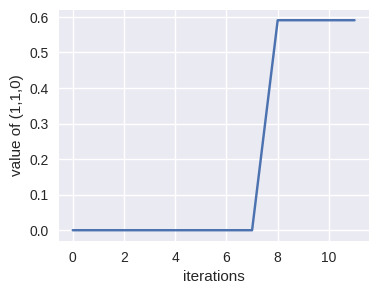

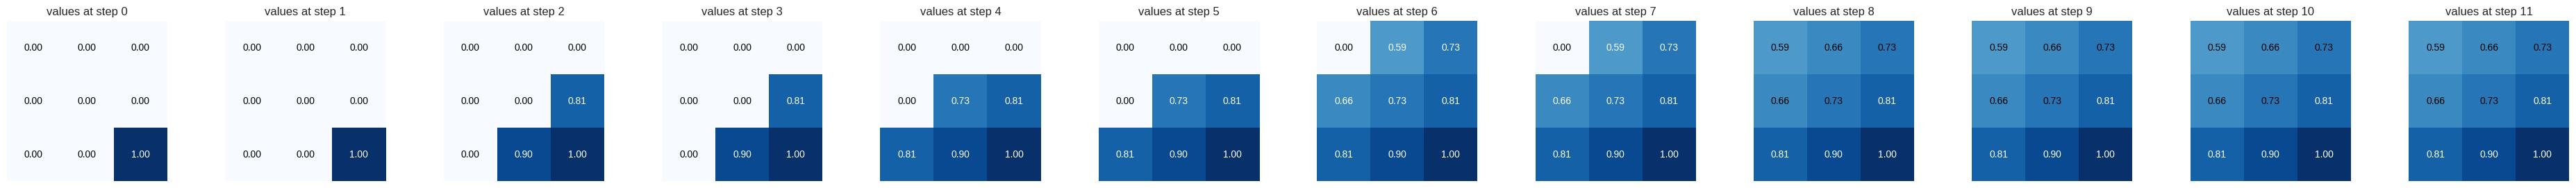

In [ ]:
visible_env.play()

visualize(PI_planner.V_logs, (1, 1, 0), 5)

### Value Iteration

**Idea**

Gradually advance to $\pi^{*}$ with combined **truncated policy evaluation** and **policy improvement** steps.

&nbsp;

**Truncated Policy Evaluation and Improvement step**

No arbitrary starting policy needed. Estimate $V^{\pi^*}$ as follows:

  * For $k = 0,1,2,\cdots, K$

    * Set $V = \mathbf{0}$ when $k = 0$ and $V_{k-1}$ otherwise
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1fsi3ZZgqZ-p061AxvSdeluWZTlwSjnGj" alt="policy evaluation and improvement" width="400"/>
      </div>

      return $V$ as $V_{k}$.


&nbsp;

#### Putting everything together

* Estimate $V^{\pi^*}$ with $V_{K} = (T^*)^{K}\mathbf{0}$
* Return $\hat{\pi}^{*}$ as the greedy policy w.r.t $V_{K}$. That is,

  $$ \hat{\pi}^{*}(s) \in \underset{a\in\mathcal{A}}{\arg\max} \bigg\{r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a)V_{K}(s')\bigg\},\quad s\in\mathcal{S}$$



&nbsp;

#### Theoretical guarantee [[2]](#scrollTo=XqJPFe6f6gFV&line=5&uniqifier=1)

VI finds an **$\mathbf{\varepsilon}$-optimal policy** ($\pi^{\varepsilon}$) satisfying

$\qquad V^* - V^{\pi^{\varepsilon}}\leq \varepsilon\,\mathbf{1}$

after $K = \mathcal{O}(\ln(2\gamma/\varepsilon(1-\gamma)^2)/(1-\gamma))$ iterations.


In [ ]:
class ValueIteration:
  """
  Implements value iteration
  """
  def __init__(self,
              env: Env,
              gamma: float,
              epsilon: float,
              num_iterations = None,
  ):
    self.env = env
    self.states = self.env.states
    self.n_states = len(self.states)
    self.actions = self.env.actions
    self.n_actions = len(self.actions)
    self.gamma = gamma
    self.K = num_iterations
    self.V_logs = []

    if self.K is None:
      self.K = math.ceil(np.log((2*self.gamma)/(epsilon*(1-self.gamma)**2))/(1-self.gamma))

    self.policy = {state: 0 for state in self.env.states}
    self.V = {state: 0 for state in self.env.states}


  def estimate_vstar(self):
    """
    Starting from an initial guess 'V',
    iteratively estimate V^{π*} as T*V

    Assign new values to self.V
    """
    for k in range(self.K):
      for state in self.env.states:
        self.V[state] = max(map(lambda action: self.get_expected_update(state, action), self.env.actions))
      self.V_logs.append(self.V.copy())


  def get_policy(self):
    """
    Get the greedy policy:
      π(s) = argmax_{a\in A} Q(s,a)
    where
      Q(s,a) = r(s,a) + gamma*<P(.|s,a),v>

    assign new policy to self.policy
    """
    # TODO: Solve this and delete the next line
    return PolicyIteration.get_policy(self)


  def get_expected_update(self, state, action):
    """
    Compute:

      Q(s,a) = r(s,a) + gamma <p(.|s,a),V>

    :param state
    :param action

    :return Q(s,a): float
    """
    # TODO: Same as for PI. Solve this and return Q(s,a) instead
    return PolicyIteration.get_expected_update(self, state, action)

Finally, we also plan with Value Iteration.

In [ ]:
VI_planner = ValueIteration(env,
                            gamma = 0.9, #same as PI
                            epsilon = 0.01,
                            num_iterations = None) # You can set the number of iterations

VI_planner.estimate_vstar()
VI_planner.get_policy()

In [ ]:
avg_return = rollouts(env=visible_env,
                      policy=make_policy(VI_planner.policy),
                      n_trajectories=80,
                      gamma=0.9)

print(avg_return)

0.5904900000000006


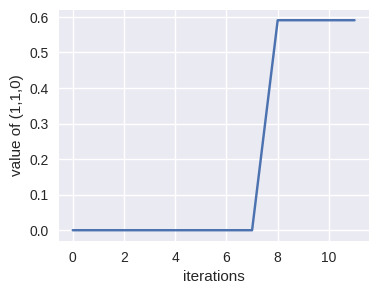

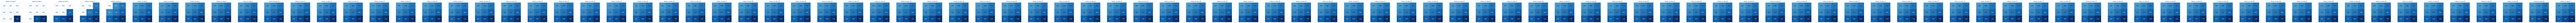

In [ ]:
visible_env.play()

visualize(VI_planner.V_logs, (1, 1, 0), 5)

## Additional Theoretical Exercises
1. ) How would policy iteration be defined for action values? Give a complete
 algorithm for computing $q^*$, analogous to the one given below for computing $v^*$.

 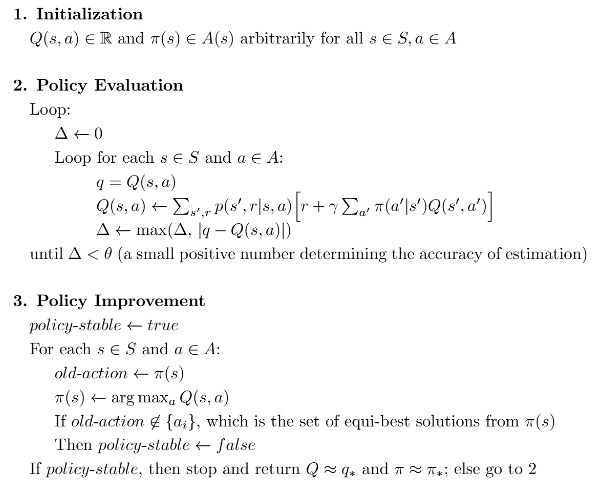

2. )  Suppose you are restricted to considering only policies that are $\epsilon$-soft,
 meaning that the probability of selecting each action in each state, $s$, is at least $\frac{ϵ}{|\mathcal{A}|}$.
 Describe qualitatively the changes that would be required in each of the steps 3, 2, and 1,
 in that order, of the policy iteration algorithm for $v^*$ given below.

**Step 3: Policy Improvement**

In an $\epsilon$-soft policy, the improvement step should not simply pick the greedy action (the action with the highest value). Instead, it should ensure that all actions are chosen with at least a probability of $\frac{\epsilon}{|A|}$, maintaining some level of exploration. This can be done by setting the probability of the best action to $1 - \epsilon + \frac{\epsilon}{|A|}$ and distributing the remaining probability $\frac{\epsilon}{|A|}$ among all actions. This modification ensures that the policy remains $\epsilon$-soft while still preferring the action that appears to be optimal.

**Step 2: Policy Evaluation**

Step 2 remains largely unaffected by the $\epsilon$-soft constraint since it only involves updating the value function $V(s)$ based on the current policy $\pi$. However, the only requirement is that during this evaluation process, the policy $\pi$ used in the Bellman expectation equation should already be an $\epsilon$-soft policy. This ensures that the value function reflects the $\epsilon$-soft behavior, where exploration is maintained.

**Step 1: Initialization**

Initialization should ensure that the starting policy is $\epsilon$-soft, meaning that each action has at least a probability of $\frac{\epsilon}{|A|}$ in every state. This guarantees that the policy respects the $\epsilon$-soft constraint from the beginning of the iteration process.




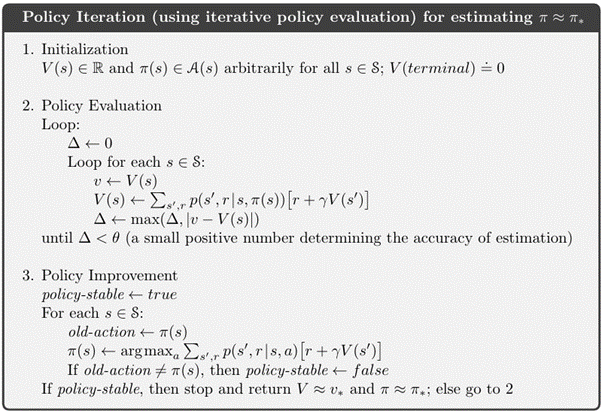

## Credit:
1. https://github.com/rlsummerschool/practical-sessions/blob/master/notebooks/DP_practice.ipynb
2.   Bruno Scherrer, "a lecture on Markov Decision Processes and Dynamic Programming", June 2023, [Slides](https://drive.google.com/file/d/1sFh0TyU_nq60R7kouPg6MCI4IMYicSII/view?usp=sharing)
3.   Csaba Szepesvári "a lecture series on Theoretical Foundations of Reinforcement Learning", 2020, [RL Theory course](https://rltheory.github.io/)
4.   Richard S. Sutton, Andrew G. Barto "Reinforcement Learning: An Introduction", second edition, 2020, [Book](http://incompleteideas.net/book/RLbook2020.pdf)



